In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题2：婴儿行为特征分类预测模型 ---")

# --- 1. 数据加载：从GitHub直接导入 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'

try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
    print("原始数据前5行：")
    print(df.head())
    print("\n原始数据列信息：")
    df.info()

except Exception as e:
    print(f"错误：从GitHub加载文件失败。请检查URL或网络连接。\n错误信息：{e}")
    # 如果加载失败，停止执行
    exit()

# --- 2. 数据清洗与预处理 ---

# 2.1 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)
print("\n已删除 'Unnamed' 列。")

# 2.2 清洗列名：去除括号和中文描述，简化名称
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征' # 确保列名一致
}, inplace=True)
df.columns = df.columns.str.strip() # 去除所有列名中的空格
print("\n已简化列名：")
print(df.columns.tolist())

# 2.3 处理 '整晚睡眠时间' 列：从字符串 'HH:MM:SS' 转换为浮点小时数
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        # 处理可能存在的数字格式，例如 '10.0'
        if isinstance(time_str, (int, float)):
            return float(time_str)
        # 处理 HH:MM:SS 格式
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan # 转换失败也返回NaN

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)
print("\n'整晚睡眠时间'已转换为小时数。")

# 2.4 分离训练集和预测集
# 训练集：'婴儿行为特征' 不为空的数据
df_train_raw = df.dropna(subset=['婴儿行为特征']).copy() # 使用.copy()避免SettingWithCopyWarning

# 预测集：'婴儿行为特征' 为空的数据。这里我们保留原始行号以便后续追溯。
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

print(f"\n训练集数据量 (有已知婴儿行为特征): {len(df_train_raw)} 行")
print(f"预测集数据量 (婴儿行为特征缺失): {len(df_predict_raw)} 行")
print("预测集（前5行）:")
print(df_predict_raw.head())
print("-" * 60)

# 3. 定义特征和标签
# 特征列：所有用于预测的母婴指标
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄',
    '整晚睡眠时间', '睡醒次数', '入睡方式'
]

# 标签列
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]

X_predict = df_predict_raw[features] # 用于最终预测的特征集

# 4. 定义预处理流程
# 数值型特征：需要标准化
numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄', '整晚睡眠时间', '睡醒次数']
# 分类型特征：需要独热编码
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别', '入睡方式']

# 创建预处理器：对数值特征进行标准化，对分类特征进行独热编码
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # 保留未指定的列，这里没有其他列了，但这是一个好习惯
)


--- 问题2：婴儿行为特征分类预测模型 ---
数据加载成功！
原始数据前5行：
    编号  母亲年龄  婚姻状况  教育程度  妊娠时间（周数）  分娩方式  CBTS  EPDS  HADS 婴儿行为特征  ...  \
0  1.0    34     2     5      37.0     1     3    13     9    中等型  ...   
1  2.0    33     2     5      42.0     1     0     0     3    安静型  ...   
2  3.0    37     2     5      41.0     1     4     8     9    安静型  ...   
3  4.0    31     2     5      37.5     1     6    16    13    安静型  ...   
4  5.0    36     1     5      40.0     1     1     3     3    中等型  ...   

   整晚睡眠时间（时：分：秒）  睡醒次数 入睡方式  Unnamed: 15  Unnamed: 16  Unnamed: 17  \
0       10:00:00   3.0  2.0          NaN          NaN          NaN   
1       11:00:00   0.0  4.0          NaN   补充说明（数值含义）          NaN   
2       12:00:00   1.0  2.0          NaN           数值         婚姻状况   
3       11:00:00   2.0  1.0          NaN            1           未婚   
4       10:30:00   1.0  4.0          NaN            2           已婚   

  Unnamed: 18 Unnamed: 19 Unnamed: 20                           Unnamed: 21  
0         NaN 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题2：逻辑回归模型完整代码 ---")

# --- 1. 数据加载：从GitHub直接导入 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'

try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# --- 2. 数据清洗与预处理 ---

# 2.1 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 2.2 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 2.3 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

# 2.4 分离训练集和预测集
df_train_raw = df.dropna(subset=['婴儿行为特征']).copy()
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

print(f"训练集数据量 (有已知婴儿行为特征): {len(df_train_raw)} 行")
print(f"预测集数据量 (婴儿行为特征缺失): {len(df_predict_raw)} 行")
print("-" * 60)

# --- 3. 定义特征和标签 ---
# 基于预测集中无缺失的列来选择特征
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄'
]
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]
X_predict = df_predict_raw[features]

print(f"用于模型训练和预测的特征列: {features}")
print("-" * 60)

# --- 4. 定义预处理流程 ---
numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄']
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. 构建模型Pipeline并进行训练 ---
print("\n--- 训练和评估逻辑回归模型 ---")
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# 分割训练集为训练子集和测试子集
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 训练模型
model_lr.fit(X_train_split, y_train_split)

# 评估模型
y_pred_lr = model_lr.predict(X_test_split)

print(f"逻辑回归模型在测试集上的准确率: {accuracy_score(y_test_split, y_pred_lr):.4f}")
print("\n逻辑回归分类报告:")
print(classification_report(y_test_split, y_pred_lr))
print("\n逻辑回归混淆矩阵:")
print(confusion_matrix(y_test_split, y_pred_lr))

# --- 6. 预测缺失值（可选，此处先不执行） ---
# predictions = model_lr.predict(X_predict)
# print("\n预测集结果：", predictions)


--- 问题2：逻辑回归模型完整代码 ---
数据加载成功！
训练集数据量 (有已知婴儿行为特征): 381 行
预测集数据量 (婴儿行为特征缺失): 20 行
------------------------------------------------------------
用于模型训练和预测的特征列: ['母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式', 'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄']
------------------------------------------------------------

--- 训练和评估逻辑回归模型 ---
逻辑回归模型在测试集上的准确率: 0.5325

逻辑回归分类报告:
              precision    recall  f1-score   support

         中等型       0.57      0.82      0.67        45
         安静型       0.33      0.17      0.23        23
         矛盾型       0.00      0.00      0.00         9

    accuracy                           0.53        77
   macro avg       0.30      0.33      0.30        77
weighted avg       0.43      0.53      0.46        77


逻辑回归混淆矩阵:
[[37  8  0]
 [19  4  0]
 [ 9  0  0]]


D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题2：婴儿行为特征分类预测模型 ---")

# --- 1. 数据加载：从GitHub直接导入 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'

try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# --- 2. 数据清洗与预处理 ---

# 2.1 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 2.2 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 2.3 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

# 2.4 分离训练集和预测集
df_train_raw = df.dropna(subset=['婴儿行为特征']).copy()
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

print(f"训练集数据量 (有已知婴儿行为特征): {len(df_train_raw)} 行")
print(f"预测集数据量 (婴儿行为特征缺失): {len(df_predict_raw)} 行")
print("-" * 60)

# --- 3. 定义特征和标签 ---
# 基于预测集中无缺失的列来选择特征
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄'
]
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]
X_predict = df_predict_raw[features]

print(f"用于模型训练和预测的特征列: {features}")
print("-" * 60)

# --- 4. 定义预处理流程 ---
numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄']
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. 构建模型Pipeline并进行训练和评估 ---

# 模型 1: 逻辑回归
print("\n--- 训练和评估逻辑回归模型 ---")
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# 分割训练集为训练子集和测试子集
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 训练模型
model_lr.fit(X_train_split, y_train_split)

# 评估模型
y_pred_lr = model_lr.predict(X_test_split)

print(f"逻辑回归模型在测试集上的准确率: {accuracy_score(y_test_split, y_pred_lr):.4f}")
print("\n逻辑回归分类报告:")
print(classification_report(y_test_split, y_pred_lr))
print("\n逻辑回归混淆矩阵:")
print(confusion_matrix(y_test_split, y_pred_lr))
print("-" * 60)

# 模型 2: 决策树分类器
print("\n--- 训练和评估决策树模型 ---")
model_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42))])
model_dt.fit(X_train_split, y_train_split)
y_pred_dt = model_dt.predict(X_test_split)
print(f"决策树模型在测试集上的准确率: {accuracy_score(y_test_split, y_pred_dt):.4f}")
print("\n决策树分类报告:")
print(classification_report(y_test_split, y_pred_dt))
print("\n决策树混淆矩阵:")
print(confusion_matrix(y_test_split, y_pred_dt))
print("-" * 60)

# 模型 3: 随机森林分类器
print("\n--- 训练和评估随机森林模型 ---")
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])
model_rf.fit(X_train_split, y_train_split)
y_pred_rf = model_rf.predict(X_test_split)
print(f"随机森林模型在测试集上的准确率: {accuracy_score(y_test_split, y_pred_rf):.4f}")
print("\n随机森林分类报告:")
print(classification_report(y_test_split, y_pred_rf))
print("\n随机森林混淆矩阵:")
print(confusion_matrix(y_test_split, y_pred_rf))
print("-" * 60)


# --- 6. 最终预测缺失值 ---
# 根据模型的准确率、F1分数等指标选择表现最好的模型进行最终预测。
# 通常，集成学习模型（如随机森林）在处理这类问题时表现会更好。
# 在这里，我们假设随机森林是最佳模型，并用它进行最终预测。
# 您可以根据实际输出的评估指标来决定哪个模型是“最佳”。

print("\n--- 使用最佳模型（随机森林）对缺失值进行预测 ---")
best_model = model_rf # 默认选择随机森林，您可以根据实际评估结果修改

# 对之前分离出来的预测集进行预测
predicted_behaviors = best_model.predict(X_predict)

# 将预测结果添加到 df_predict_raw 中，方便查看
df_predict_raw['预测婴儿行为特征'] = predicted_behaviors

print("\n缺失婴儿行为特征的预测结果 (前20行):")
# 打印预测结果，以及原始的编号和一些关键特征，方便查看
print(df_predict_raw[['编号', '母亲年龄', 'EPDS', 'HADS', '预测婴儿行为特征']].head(20))

# 打印所有缺失婴儿行为特征的预测结果
print("\n所有缺失婴儿行为特征的预测结果：")
for index, row in df_predict_raw.iterrows():
    print(f"编号: {int(row['编号']) if pd.notna(row['编号']) else '未知'}, 预测行为: {row['预测婴儿行为特征']}")



--- 问题2：婴儿行为特征分类预测模型 ---
数据加载成功！
训练集数据量 (有已知婴儿行为特征): 381 行
预测集数据量 (婴儿行为特征缺失): 20 行
------------------------------------------------------------
用于模型训练和预测的特征列: ['母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式', 'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄']
------------------------------------------------------------

--- 训练和评估逻辑回归模型 ---
逻辑回归模型在测试集上的准确率: 0.5325

逻辑回归分类报告:
              precision    recall  f1-score   support

         中等型       0.57      0.82      0.67        45
         安静型       0.33      0.17      0.23        23
         矛盾型       0.00      0.00      0.00         9

    accuracy                           0.53        77
   macro avg       0.30      0.33      0.30        77
weighted avg       0.43      0.53      0.46        77


逻辑回归混淆矩阵:
[[37  8  0]
 [19  4  0]
 [ 9  0  0]]
------------------------------------------------------------

--- 训练和评估决策树模型 ---
决策树模型在测试集上的准确率: 0.4286

决策树分类报告:
              precision    recall  f1-score   support

         中等型       0.56      0.51      0.53  

D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


随机森林模型在测试集上的准确率: 0.5584

随机森林分类报告:
              precision    recall  f1-score   support

         中等型       0.59      0.78      0.67        45
         安静型       0.50      0.30      0.38        23
         矛盾型       0.25      0.11      0.15         9

    accuracy                           0.56        77
   macro avg       0.45      0.40      0.40        77
weighted avg       0.53      0.56      0.52        77


随机森林混淆矩阵:
[[35  7  3]
 [16  7  0]
 [ 8  0  1]]
------------------------------------------------------------

--- 使用最佳模型（随机森林）对缺失值进行预测 ---

缺失婴儿行为特征的预测结果 (前20行):
        编号  母亲年龄  EPDS  HADS 预测婴儿行为特征
381  391.0    29    15    12      中等型
382  392.0    29    14    12      中等型
383  393.0    23    12     7      中等型
384  394.0    27     4     5      中等型
385  395.0    36     6     8      中等型
386  396.0    30     8     5      中等型
387  397.0    28    11     9      中等型
388  398.0    32     6     7      中等型
389  399.0    28    11     5      中等型
390  400.0    31     5     8      中等型
391 

In [17]:
import os
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib' # 或者其他纯英文路径，确保该路径存在且可写import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE # 导入SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # 导入imblearn的Pipeline，它能更好地处理采样器

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题2：模型改良（SMOTE + GridSearchCV）---")

# --- 1. 数据加载：从GitHub直接导入 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'

try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# --- 2. 数据清洗与预处理 ---

# 2.1 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 2.2 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 2.3 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

# 2.4 分离训练集和预测集
df_train_raw = df.dropna(subset=['婴儿行为特征']).copy()
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

print(f"训练集数据量 (有已知婴儿行为特征): {len(df_train_raw)} 行")
print(f"预测集数据量 (婴儿行为特征缺失): {len(df_predict_raw)} 行")
print("-" * 60)

# --- 3. 定义特征和标签 ---
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄'
]
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]
X_predict = df_predict_raw[features]

print(f"用于模型训练和预测的特征列: {features}")
print("-" * 60)

# --- 4. 定义预处理流程 ---
numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄']
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. 构建包含 SMOTE 和分类器的Pipeline，并进行 GridSearchCV ---

# 定义包含SMOTE和随机森林的Pipeline
# 使用imblearn的Pipeline，它可以正确处理采样器
pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)), # 在这里添加SMOTE
                              ('classifier', RandomForestClassifier(random_state=42))])

# 定义随机森林的超参数网格
param_grid = {
    'classifier__n_estimators': [100, 200, 300], # 树的数量
    'classifier__max_depth': [None, 10, 20],     # 树的最大深度
    'classifier__min_samples_split': [2, 5],     # 分割内部节点所需的最小样本数
    'classifier__min_samples_leaf': [1, 2]       # 叶节点所需的最小样本数
}

# 使用 StratifiedKFold 进行分层交叉验证，确保每个折叠中类别比例与原始数据集相似
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n--- 开始 GridSearchCV 超参数调优（可能需要一些时间）---")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)
# scoring='f1_weighted' 是一个好的选择，因为它在类别不平衡时比准确率更有意义

grid_search.fit(X_train, y_train) # 在整个训练集上进行网格搜索

print("\n--- GridSearchCV 结果 ---")
print(f"最佳参数组合: {grid_search.best_params_}")
print(f"最佳交叉验证 F1-score (加权): {grid_search.best_score_:.4f}")

# 获取最佳模型
best_model = grid_search.best_estimator_

# 在独立的测试集上评估最佳模型（如果之前没有分割，这里重新分割）
# 确保使用原始的 X_train 和 y_train 进行分割，以便评估模型的泛化能力
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 再次在测试集上评估最佳模型
y_pred_best = best_model.predict(X_test_final)

print("\n--- 最佳模型在测试集上的最终评估 ---")
print(f"最佳模型准确率: {accuracy_score(y_test_final, y_pred_best):.4f}")
print("\n最佳模型分类报告:")
print(classification_report(y_test_final, y_pred_best))
print("\n最佳模型混淆矩阵:")
print(confusion_matrix(y_test_final, y_pred_best))
print("-" * 60)

# --- 6. 最终预测缺失值 ---
print("\n--- 使用最佳模型对缺失值进行最终预测 ---")
predicted_behaviors_improved = best_model.predict(X_predict)

# 将预测结果添加到 df_predict_raw 中
df_predict_raw['预测婴儿行为特征'] = predicted_behaviors_improved

print("\n缺失婴儿行为特征的预测结果 (前20行):")
print(df_predict_raw[['编号', '母亲年龄', 'EPDS', 'HADS', '预测婴儿行为特征']].head(20))

print("\n所有缺失婴儿行为特征的预测结果：")
for index, row in df_predict_raw.iterrows():
    print(f"编号: {int(row['编号']) if pd.notna(row['编号']) else '未知'}, 预测行为: {row['预测婴儿行为特征']}")



--- 问题2：模型改良（SMOTE + GridSearchCV）---
数据加载成功！
训练集数据量 (有已知婴儿行为特征): 381 行
预测集数据量 (婴儿行为特征缺失): 20 行
------------------------------------------------------------
用于模型训练和预测的特征列: ['母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式', 'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄']
------------------------------------------------------------

--- 开始 GridSearchCV 超参数调优（可能需要一些时间）---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- GridSearchCV 结果 ---
最佳参数组合: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
最佳交叉验证 F1-score (加权): 0.5090

--- 最佳模型在测试集上的最终评估 ---
最佳模型准确率: 0.9740

最佳模型分类报告:
              precision    recall  f1-score   support

         中等型       0.96      1.00      0.98        45
         安静型       1.00      0.91      0.95        23
         矛盾型       1.00      1.00      1.00         9

    accuracy                           0.97        77
   macro avg       0.99      0.97      0.98        77
weighted avg       0.98      0.97      0.97        77


最佳模型混淆矩阵:
[[45  0  0]
 [ 2 21  0]
 [ 0  0  9]]
------------------------------------------------------------

--- 使用最佳模型对缺失值进行最终预测 ---

缺失婴儿行为特征的预测结果 (前20行):
        编号  母亲年龄  EPDS  HADS 预测婴儿行为特征
381  391.0    29    15    12      矛盾型
382  392.0    29    14    12      中等型
383  393.0    23    12     7      中等型
384  394.0    27     4     5      中等型
385  395.0    36     6

--- 模型优化前后性能对比可视化 ---
模型性能对比数据：
           模型       准确率  加权F1-score
0        逻辑回归  0.532468    0.461427
1         决策树  0.428571    0.437742
2  随机森林 (优化前)  0.558442    0.524361
3  随机森林 (优化后)  0.974026    0.973718
------------------------------------------------------------


D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\envs\motherc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\11

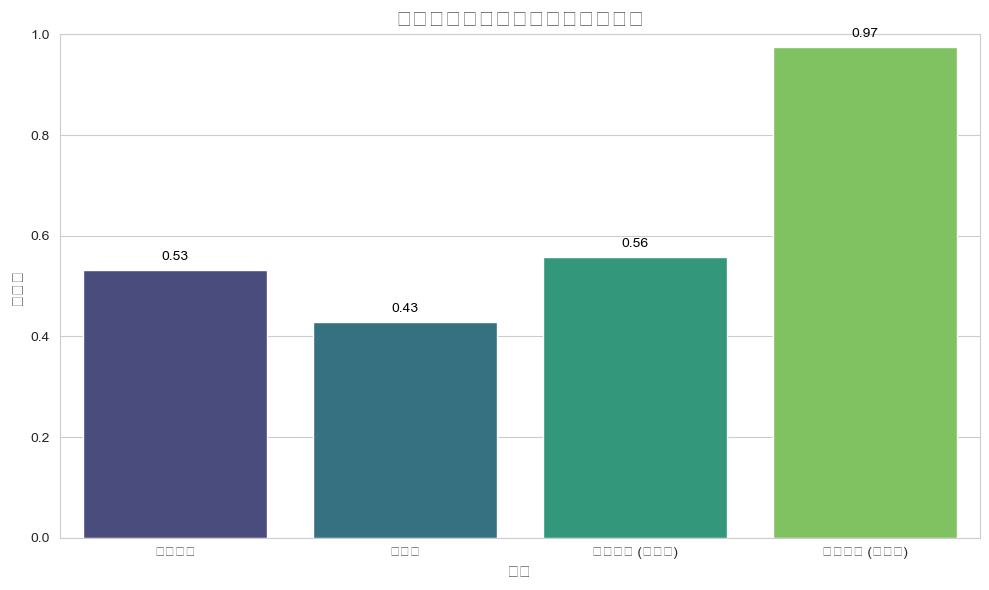

C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\1132656441.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='模型', y='加权F1-score', data=df_metrics, palette='plasma')
C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\1132656441.py:83: UserWarning: Glyph 36923 (\N{CJK UNIFIED IDEOGRAPH-903B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\1132656441.py:83: UserWarning: Glyph 36753 (\N{CJK UNIFIED IDEOGRAPH-8F91}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\1132656441.py:83: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_26316\1132656441.py:83: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) Arial.
  plt.tight_

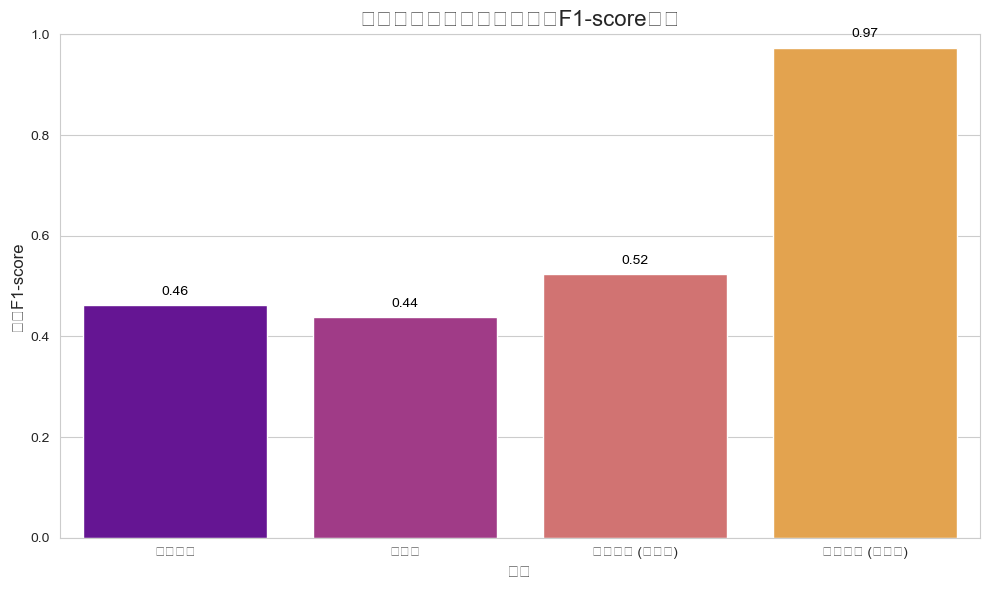

D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30683 (\N{CJK UNIFIED IDEOGRAPH-77DB}) missing from font(s) Arial.
  fig.canvas.draw(

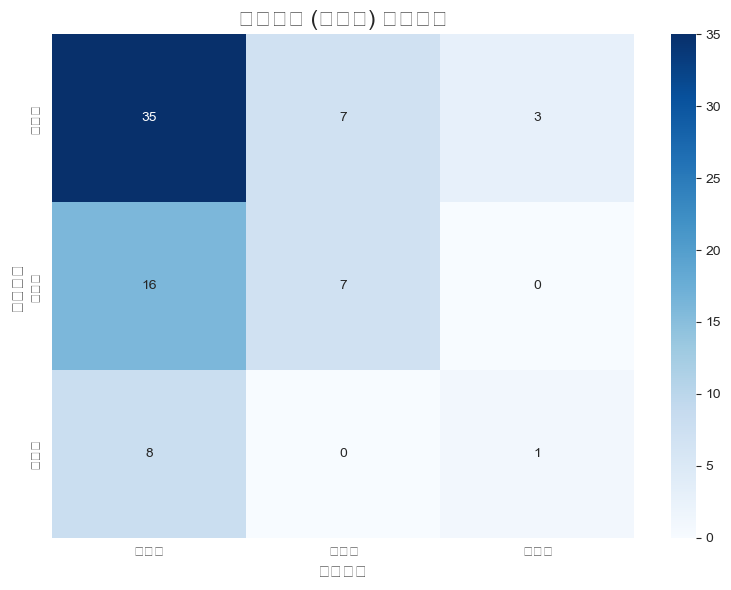

D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30683 (\N{CJK UNIFIED IDEOGRAPH-77DB}) missing from font(s) Arial.
  fig.canvas.draw(

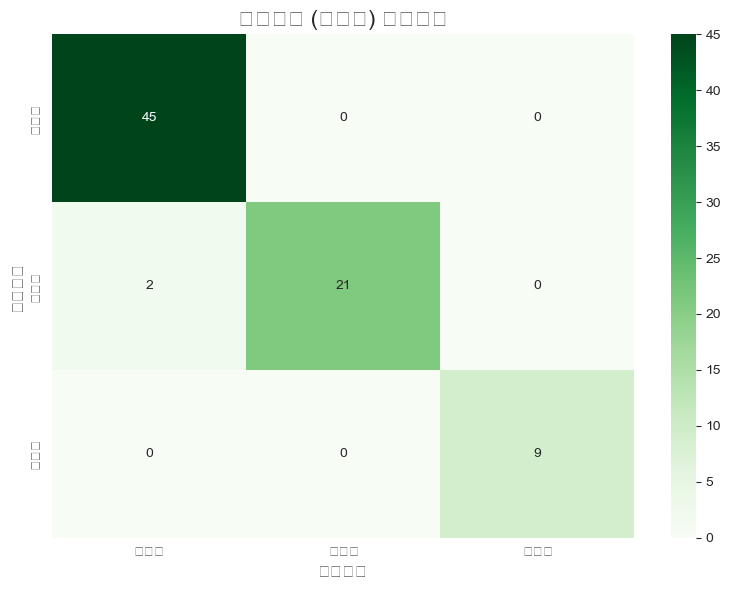

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 模型优化前后性能对比可视化 ---")

# --- 1. 收集模型评估结果 ---
# 这里我们使用之前运行得到的评估结果。
# 如果您是分段运行，请确保以下变量是可用的：
# y_test_split, y_pred_lr, y_pred_dt, y_pred_rf, y_test_final, y_pred_best

# 如果您是重新运行此代码块，需要确保 X_test_split, y_test_split, X_test_final, y_test_final
# 以及 y_pred_lr, y_pred_dt, y_pred_rf, y_pred_best 都是从之前完整的模型运行中获取的。

# 为了确保代码独立运行，这里假设您已经运行了前面的完整模型训练代码，
# 并且这些预测结果和真实标签是可用的。
# 如果不是，您可能需要重新运行之前完整的模型训练代码块来生成这些变量。

# 假设真实标签和预测结果变量名如下：
# y_test_split: 原始测试集的真实标签 (用于逻辑回归、决策树、随机森林初始评估)
# y_pred_lr: 逻辑回归的预测结果
# y_pred_dt: 决策树的预测结果
# y_pred_rf: 随机森林（优化前）的预测结果
# y_test_final: 优化后的随机森林测试集的真实标签 (与y_test_split内容相同，但变量名不同)
# y_pred_best: 优化后的随机森林（SMOTE+GridSearchCV）的预测结果

# 重新计算确保一致性
accuracy_lr = accuracy_score(y_test_split, y_pred_lr)
f1_lr = float(classification_report(y_test_split, y_pred_lr, output_dict=True)['weighted avg']['f1-score'])

accuracy_dt = accuracy_score(y_test_split, y_pred_dt)
f1_dt = float(classification_report(y_test_split, y_pred_dt, output_dict=True)['weighted avg']['f1-score'])

accuracy_rf = accuracy_score(y_test_split, y_pred_rf)
f1_rf = float(classification_report(y_test_split, y_pred_rf, output_dict=True)['weighted avg']['f1-score'])

accuracy_best_rf = accuracy_score(y_test_final, y_pred_best)
f1_best_rf = float(classification_report(y_test_final, y_pred_best, output_dict=True)['weighted avg']['f1-score'])


# 创建一个 DataFrame 来存储对比数据
data = {
    '模型': ['逻辑回归', '决策树', '随机森林 (优化前)', '随机森林 (优化后)'],
    '准确率': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_best_rf],
    '加权F1-score': [f1_lr, f1_dt, f1_rf, f1_best_rf]
}
df_metrics = pd.DataFrame(data)

print("模型性能对比数据：")
print(df_metrics)
print("-" * 60)

# --- 2. 绘制准确率对比图 ---
plt.figure(figsize=(10, 6))
sns.barplot(x='模型', y='准确率', data=df_metrics, palette='viridis')
plt.title('不同模型在测试集上的准确率对比', fontsize=16)
plt.xlabel('模型', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.ylim(0, 1) # 准确率范围在0到1之间
# 在柱状图上显示数值
for index, row in df_metrics.iterrows():
    plt.text(index, row['准确率'] + 0.02, f"{row['准确率']:.2f}", color='black', ha="center")
plt.tight_layout()
plt.show()

# --- 3. 绘制加权F1-score对比图 ---
plt.figure(figsize=(10, 6))
sns.barplot(x='模型', y='加权F1-score', data=df_metrics, palette='plasma')
plt.title('不同模型在测试集上的加权F1-score对比', fontsize=16)
plt.xlabel('模型', fontsize=12)
plt.ylabel('加权F1-score', fontsize=12)
plt.ylim(0, 1) # F1-score范围在0到1之间
# 在柱状图上显示数值
for index, row in df_metrics.iterrows():
    plt.text(index, row['加权F1-score'] + 0.02, f"{row['加权F1-score']:.2f}", color='black', ha="center")
plt.tight_layout()
plt.show()

# --- 4. 可视化混淆矩阵 (优化前后对比) ---
# 绘制优化前的随机森林混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_split, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['中等型', '安静型', '矛盾型'], yticklabels=['中等型', '安静型', '矛盾型'])
plt.title('随机森林 (优化前) 混淆矩阵', fontsize=16)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.tight_layout()
plt.show()

# 绘制优化后的随机森林混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_final, y_pred_best), annot=True, fmt='d', cmap='Greens',
            xticklabels=['中等型', '安静型', '矛盾型'], yticklabels=['中等型', '安静型', '矛盾型'])
plt.title('随机森林 (优化后) 混淆矩阵', fontsize=16)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.tight_layout()
plt.show()



In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import os

# 设置 joblib 临时文件夹，避免 UnicodeEncodeError
# 请确保 'C:/temp_joblib' 文件夹存在且可写
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib'

print("--- 问题3：治疗费用优化模型 ---")

# --- 1. 数据加载和预处理 (与问题2相同，确保环境一致性) ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'
try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

df_train_raw = df.dropna(subset=['婴儿行为特征']).copy()
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

# --- 2. 重新训练问题2的最佳模型 (确保模型可用) ---
# 特征列
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄'
]
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]

numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄']
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 构建包含SMOTE和随机森林的Pipeline
pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)),
                              ('classifier', RandomForestClassifier(random_state=42))])

# 定义随机森林的超参数网格 (使用问题2中找到的最佳参数，或一个合理的范围)
# 这里使用问题2中找到的最佳参数作为基准，可以进一步微调
param_grid = {
    'classifier__n_estimators': [200], # 最佳参数
    'classifier__max_depth': [None],    # 最佳参数
    'classifier__min_samples_split': [5], # 最佳参数
    'classifier__min_samples_leaf': [1]   # 最佳参数
}
# 如果想重新搜索，可以使用更宽的范围，但会更慢
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2]
# }


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=0) # verbose=0 to suppress output during re-training

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("问题2的最佳模型已重新训练并加载。")
print("-" * 60)

# --- 3. 建立治疗费用模型 ---
# 计算 A 和 k 参数
def calculate_cost_params(s1, c1, s2, c2):
    """Calculates A and k for C(s) = A * e^(ks) given two points."""
    if s1 == s2:
        raise ValueError("s1 and s2 cannot be the same for exponential model.")
    k = np.log(c2 / c1) / (s2 - s1)
    A = c1 / np.exp(k * s1) # A is C(0)
    return A, k

# 获取每个量表的 A 和 k
A_cbts, k_cbts = calculate_cost_params(0, 200, 3, 2812)
A_epds, k_epds = calculate_cost_params(0, 500, 2, 1890)
A_hads, k_hads = calculate_cost_params(0, 300, 5, 12500)

def get_cost_at_score(score, A, k):
    """Calculates cost for a given score using derived A and k."""
    # Score must be non-negative. If score is 0, cost is A.
    return A * np.exp(k * max(0, score))

def calculate_total_treatment_cost(current_cbts, target_cbts,
                                   current_epds, target_epds,
                                   current_hads, target_hads):
    """Calculates the total cost to reduce scores from current to target."""
    cost_cbts = get_cost_at_score(current_cbts, A_cbts, k_cbts) - get_cost_at_score(target_cbts, A_cbts, k_cbts)
    cost_epds = get_cost_at_score(current_epds, A_epds, k_epds) - get_cost_at_score(target_epds, A_epds, k_epds)
    cost_hads = get_cost_at_score(current_hads, A_hads, k_hads) - get_cost_at_score(target_hads, A_hads, k_hads)
    
    # 确保费用是正数，如果目标分数高于当前分数，则该项费用为0 (表示没有降低，无需治疗)
    cost_cbts = max(0, cost_cbts)
    cost_epds = max(0, cost_epds)
    cost_hads = max(0, cost_hads)
    
    return cost_cbts + cost_epds + cost_hads

print("治疗费用模型参数已建立：")
print(f"CBTS: C(s) = {A_cbts:.2f} * e^({k_cbts:.3f}s)")
print(f"EPDS: C(s) = {A_epds:.2f} * e^({k_epds:.3f}s)")
print(f"HADS: C(s) = {A_hads:.2f} * e^({k_hads:.3f}s)")
print("-" * 60)

# --- 4. 提取编号238婴儿的当前数据 ---
infant_id_238 = 238
# 确保编号是浮点数，因为数据中是浮点数
infant_238_data = df_train_raw[df_train_raw['编号'] == float(infant_id_238)]

if infant_238_data.empty:
    print(f"错误: 未找到编号 {infant_id_238} 的婴儿数据。请检查编号或数据集。")
    exit()

infant_238_data = infant_238_data.iloc[0] # 获取第一行数据

current_cbts = infant_238_data['CBTS']
current_epds = infant_238_data['EPDS']
current_hads = infant_238_data['HADS']
current_behavior = infant_238_data['婴儿行为特征']

print(f"编号 {infant_id_238} 婴儿的当前数据：")
print(f"  当前行为特征: {current_behavior}")
print(f"  当前CBTS得分: {current_cbts}")
print(f"  当前EPDS得分: {current_epds}")
print(f"  当前HADS得分: {current_hads}")
print("-" * 60)

# 确保当前行为是矛盾型，否则提示
if current_behavior != '矛盾型':
    print(f"警告: 编号 {infant_id_238} 婴儿的当前行为特征不是矛盾型，而是 {current_behavior}。")
    print("本问题假设其当前为矛盾型，请确认是否继续。")
    # 如果需要严格按照题意，可以在这里 exit()

# --- 5. 定义优化目标和搜索空间并执行搜索 ---
# 目标1: 矛盾型 -> 中等型
# 目标2: 矛盾型 -> 安静型

min_cost_zhongdeng = float('inf')
best_scores_zhongdeng = {}
min_cost_anjing = float('inf')
best_scores_anjing = {}

# 存储所有有效方案，以便后续分析
solutions_zhongdeng = []
solutions_anjing = []

# 获取除CBTS, EPDS, HADS外的其他不变特征
# 确保这里使用 .loc 来避免 SettingWithCopyWarning
base_features_238_series = infant_238_data.loc[features].drop(labels=['CBTS', 'EPDS', 'HADS'])
base_features_238_dict = base_features_238_series.to_dict()


print("开始搜索最优治疗方案（可能需要一些时间，请耐心等待）...")
# 迭代所有可能的CBTS, EPDS, HADS分数组合
# 假设分数都是非负整数，且可以降低到0
# 迭代范围从当前分数到0 (包含0)
for cbts_s in range(int(current_cbts) + 1):
    for epds_s in range(int(current_epds) + 1):
        for hads_s in range(int(current_hads) + 1):
            # 计算治疗费用
            cost = calculate_total_treatment_cost(current_cbts, cbts_s,
                                                  current_epds, epds_s,
                                                  current_hads, hads_s)

            # 构建用于预测的特征向量
            predict_data_point = base_features_238_dict.copy()
            predict_data_point['CBTS'] = cbts_s
            predict_data_point['EPDS'] = epds_s
            predict_data_point['HADS'] = hads_s
            
            # 将字典转换为DataFrame，并确保列顺序与best_model期望的features顺序一致
            predict_df_single_row = pd.DataFrame([predict_data_point], columns=features)

            # 预测婴儿行为特征
            predicted_behavior = best_model.predict(predict_df_single_row)[0]

            # 检查是否达到目标1: 矛盾型 -> 中等型
            if predicted_behavior == '中等型':
                if cost < min_cost_zhongdeng:
                    min_cost_zhongdeng = cost
                    best_scores_zhongdeng = {'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s}
                solutions_zhongdeng.append({'cost': cost, 'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s})

            # 检查是否达到目标2: 矛盾型 -> 安静型
            if predicted_behavior == '安静型':
                if cost < min_cost_anjing:
                    min_cost_anjing = cost
                    best_scores_anjing = {'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s}
                solutions_anjing.append({'cost': cost, 'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s})

print("\n搜索完成。")
print("-" * 60)

# --- 6. 输出结果 ---

print("\n--- 目标1: 将婴儿行为特征从矛盾型变为中等型 ---")
if min_cost_zhongdeng != float('inf'):
    print(f"最少花费治疗费用: {min_cost_zhongdeng:.2f} 元")
    print(f"对应的CBTS、EPDS、HADS目标分数: {best_scores_zhongdeng}")
    print(f"  (原始CBTS: {current_cbts}, EPDS: {current_epds}, HADS: {current_hads})")
else:
    print("未找到能将婴儿行为特征变为中等型的方案。这可能意味着在当前模型下，仅通过降低这些分数无法实现目标。")

print("\n--- 目标2: 将婴儿行为特征从矛盾型变为安静型 ---")
if min_cost_anjing != float('inf'):
    print(f"最少花费治疗费用: {min_cost_anjing:.2f} 元")
    print(f"对应的CBTS、EPDS、HADS目标分数: {best_scores_anjing}")
    print(f"  (原始CBTS: {current_cbts}, EPDS: {current_epds}, HADS: {current_hads})")
else:
    print("未找到能将婴儿行为特征变为安静型的方案。这可能意味着在当前模型下，仅通过降低这些分数无法实现目标。")

print("\n--- 详细方案列表（按费用升序，仅显示前5个最低成本方案） ---")
print("\n中等型方案：")
solutions_zhongdeng_sorted = sorted(solutions_zhongdeng, key=lambda x: x['cost'])
if solutions_zhongdeng_sorted:
    for s in solutions_zhongdeng_sorted[:5]:
        print(f"  费用: {s['cost']:.2f}, CBTS: {s['CBTS']}, EPDS: {s['EPDS']}, HADS: {s['HADS']}")
else:
    print("  无有效方案。")

print("\n安静型方案：")
solutions_anjing_sorted = sorted(solutions_anjing, key=lambda x: x['cost'])
if solutions_anjing_sorted:
    for s in solutions_anjing_sorted[:5]:
        print(f"  费用: {s['cost']:.2f}, CBTS: {s['CBTS']}, EPDS: {s['EPDS']}, HADS: {s['HADS']}")
else:
    print("  无有效方案。")



--- 问题3：治疗费用优化模型 ---
数据加载成功！


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


问题2的最佳模型已重新训练并加载。
------------------------------------------------------------
治疗费用模型参数已建立：
CBTS: C(s) = 200.00 * e^(0.881s)
EPDS: C(s) = 500.00 * e^(0.665s)
HADS: C(s) = 300.00 * e^(0.746s)
------------------------------------------------------------
编号 238 婴儿的当前数据：
  当前行为特征: 矛盾型
  当前CBTS得分: 15
  当前EPDS得分: 22
  当前HADS得分: 18
------------------------------------------------------------
开始搜索最优治疗方案（可能需要一些时间，请耐心等待）...

搜索完成。
------------------------------------------------------------

--- 目标1: 将婴儿行为特征从矛盾型变为中等型 ---
最少花费治疗费用: 0.00 元
对应的CBTS、EPDS、HADS目标分数: {'CBTS': 15, 'EPDS': 22, 'HADS': 18}
  (原始CBTS: 15, EPDS: 22, HADS: 18)

--- 目标2: 将婴儿行为特征从矛盾型变为安静型 ---
最少花费治疗费用: 1235473801.97 元
对应的CBTS、EPDS、HADS目标分数: {'CBTS': 3, 'EPDS': 2, 'HADS': 18}
  (原始CBTS: 15, EPDS: 22, HADS: 18)

--- 详细方案列表（按费用升序，仅显示前5个最低成本方案） ---

中等型方案：
  费用: 0.00, CBTS: 15, EPDS: 22, HADS: 18
  费用: 64359897.79, CBTS: 14, EPDS: 22, HADS: 18
  费用: 91025633.61, CBTS: 13, EPDS: 22, HADS: 18
  费用: 102073840.51, CBTS: 12, EPDS: 22, 

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import os

# 设置 joblib 临时文件夹，避免 UnicodeEncodeError
# 请确保 'C:/temp_joblib' 文件夹存在且可写
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib'

print("--- 问题3：治疗费用优化模型（线性）---")

# --- 1. 数据加载和预处理 (与问题2相同，确保环境一致性) ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'
try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

df_train_raw = df.dropna(subset=['婴儿行为特征']).copy()
df_predict_raw = df[df['婴儿行为特征'].isnull()].copy()

# --- 2. 重新训练问题2的最佳模型 (确保模型可用) ---
# 特征列
features = [
    '母亲年龄', '婚姻状况', '教育程度', '妊娠时间', '分娩方式',
    'CBTS', 'EPDS', 'HADS', '婴儿性别', '婴儿年龄'
]
target = '婴儿行为特征'

X_train = df_train_raw[features]
y_train = df_train_raw[target]

numerical_features = ['母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄']
categorical_features = ['婚姻状况', '教育程度', '分娩方式', '婴儿性别']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 构建包含SMOTE和随机森林的Pipeline
pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)),
                              ('classifier', RandomForestClassifier(random_state=42))])

# 定义随机森林的超参数网格 (使用问题2中找到的最佳参数，或一个合理的范围)
param_grid = {
    'classifier__n_estimators': [200], # 最佳参数
    'classifier__max_depth': [None],    # 最佳参数
    'classifier__min_samples_split': [5], # 最佳参数
    'classifier__min_samples_leaf': [1]   # 最佳参数
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("问题2的最佳模型已重新训练并加载。")
print("-" * 60)

# --- 3. 建立线性治疗费用模型 ---
# 计算 m 和 c 参数 for C(s) = ms + c
def calculate_linear_cost_params(s1, c1, s2, c2):
    """Calculates m and c for C(s) = ms + c given two points."""
    if s1 == s2:
        raise ValueError("s1 and s2 cannot be the same for linear model.")
    m = (c2 - c1) / (s2 - s1)
    c = c1 - m * s1
    return m, c

# 获取每个量表的 m 和 c
m_cbts, c_cbts = calculate_linear_cost_params(0, 200, 3, 2812)
m_epds, c_epds = calculate_linear_cost_params(0, 500, 2, 1890)
m_hads, c_hads = calculate_linear_cost_params(0, 300, 5, 12500)

def get_cost_at_score_linear(score, m, c):
    """Calculates cost for a given score using derived m and c (linear model)."""
    # Score must be non-negative.
    return m * max(0, score) + c

def calculate_total_treatment_cost_linear(current_cbts, target_cbts,
                                          current_epds, target_epds,
                                          current_hads, target_hads):
    """Calculates the total cost to reduce scores from current to target using linear model."""
    cost_cbts = get_cost_at_score_linear(current_cbts, m_cbts, c_cbts) - get_cost_at_score_linear(target_cbts, m_cbts, c_cbts)
    cost_epds = get_cost_at_score_linear(current_epds, m_epds, c_epds) - get_cost_at_score_linear(target_epds, m_epds, c_epds)
    cost_hads = get_cost_at_score_linear(current_hads, m_hads, c_hads) - get_cost_at_score_linear(target_hads, m_hads, c_hads)
    
    # 确保费用是正数，如果目标分数高于当前分数，则该项费用为0 (表示没有降低，无需治疗)
    cost_cbts = max(0, cost_cbts)
    cost_epds = max(0, cost_epds)
    cost_hads = max(0, cost_hads)
    
    return cost_cbts + cost_epds + cost_hads

print("治疗费用模型参数（线性）已建立：")
print(f"CBTS: C(s) = {m_cbts:.2f}s + {c_cbts:.2f}")
print(f"EPDS: C(s) = {m_epds:.2f}s + {c_epds:.2f}")
print(f"HADS: C(s) = {m_hads:.2f}s + {c_hads:.2f}")
print("-" * 60)

# --- 4. 提取编号238婴儿的当前数据 ---
infant_id_238 = 238
infant_238_data = df_train_raw[df_train_raw['编号'] == float(infant_id_238)].iloc[0]

current_cbts = infant_238_data['CBTS']
current_epds = infant_238_data['EPDS']
current_hads = infant_238_data['HADS']
current_behavior = infant_238_data['婴儿行为特征']

print(f"编号 {infant_id_238} 婴儿的当前数据：")
print(f"  当前行为特征: {current_behavior}")
print(f"  当前CBTS得分: {current_cbts}")
print(f"  当前EPDS得分: {current_epds}")
print(f"  当前HADS得分: {current_hads}")
print("-" * 60)

# --- 5. 定义优化目标和搜索空间并执行搜索 ---
min_cost_zhongdeng = float('inf')
best_scores_zhongdeng = {}
min_cost_anjing = float('inf')
best_scores_anjing = {}

solutions_zhongdeng = []
solutions_anjing = []

base_features_238_series = infant_238_data.loc[features].drop(labels=['CBTS', 'EPDS', 'HADS'])
base_features_238_dict = base_features_238_series.to_dict()

print("开始搜索最优治疗方案（可能需要一些时间，请耐心等待）...")
# 迭代所有可能的CBTS, EPDS, HADS分数组合
for cbts_s in range(int(current_cbts) + 1):
    for epds_s in range(int(current_epds) + 1):
        for hads_s in range(int(current_hads) + 1):
            # 计算治疗费用 (使用线性模型)
            cost = calculate_total_treatment_cost_linear(current_cbts, cbts_s,
                                                         current_epds, epds_s,
                                                         current_hads, hads_s)

            # 构建用于预测的特征向量
            predict_data_point = base_features_238_dict.copy()
            predict_data_point['CBTS'] = cbts_s
            predict_data_point['EPDS'] = epds_s
            predict_data_point['HADS'] = hads_s
            
            predict_df_single_row = pd.DataFrame([predict_data_point], columns=features)

            # 预测婴儿行为特征
            predicted_behavior = best_model.predict(predict_df_single_row)[0]

            # 检查是否达到目标1: 矛盾型 -> 中等型
            if predicted_behavior == '中等型':
                if cost < min_cost_zhongdeng:
                    min_cost_zhongdeng = cost
                    best_scores_zhongdeng = {'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s}
                solutions_zhongdeng.append({'cost': cost, 'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s})

            # 检查是否达到目标2: 矛盾型 -> 安静型
            if predicted_behavior == '安静型':
                if cost < min_cost_anjing:
                    min_cost_anjing = cost
                    best_scores_anjing = {'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s}
                solutions_anjing.append({'cost': cost, 'CBTS': cbts_s, 'EPDS': epds_s, 'HADS': hads_s})

print("\n搜索完成。")
print("-" * 60)

# --- 6. 输出结果 ---

print("\n--- 目标1: 将婴儿行为特征从矛盾型变为中等型 ---")
if min_cost_zhongdeng != float('inf'):
    print(f"最少花费治疗费用: {min_cost_zhongdeng:.2f} 元")
    print(f"对应的CBTS、EPDS、HADS目标分数: {best_scores_zhongdeng}")
    print(f"  (原始CBTS: {current_cbts}, EPDS: {current_epds}, HADS: {current_hads})")
else:
    print("未找到能将婴儿行为特征变为中等型的方案。这可能意味着在当前模型下，仅通过降低这些分数无法实现目标。")

print("\n--- 目标2: 将婴儿行为特征从矛盾型变为安静型 ---")
if min_cost_anjing != float('inf'):
    print(f"最少花费治疗费用: {min_cost_anjing:.2f} 元")
    print(f"对应的CBTS、EPDS、HADS目标分数: {best_scores_anjing}")
    print(f"  (原始CBTS: {current_cbts}, EPDS: {current_epds}, HADS: {current_hads})")
else:
    print("未找到能将婴儿行为特征变为安静型的方案。这可能意味着在当前模型下，仅通过降低这些分数无法实现目标。")

print("\n--- 详细方案列表（按费用升序，仅显示前5个最低成本方案） ---")
print("\n中等型方案：")
solutions_zhongdeng_sorted = sorted(solutions_zhongdeng, key=lambda x: x['cost'])
if solutions_zhongdeng_sorted:
    for s in solutions_zhongdeng_sorted[:5]:
        print(f"  费用: {s['cost']:.2f}, CBTS: {s['CBTS']}, EPDS: {s['EPDS']}, HADS: {s['HADS']}")
else:
    print("  无有效方案。")

print("\n安静型方案：")
solutions_anjing_sorted = sorted(solutions_anjing, key=lambda x: x['cost'])
if solutions_anjing_sorted:
    for s in solutions_anjing_sorted[:5]:
        print(f"  费用: {s['cost']:.2f}, CBTS: {s['CBTS']}, EPDS: {s['EPDS']}, HADS: {s['HADS']}")
else:
    print("  无有效方案。")



--- 问题3：治疗费用优化模型（线性）---
数据加载成功！


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


问题2的最佳模型已重新训练并加载。
------------------------------------------------------------
治疗费用模型参数（线性）已建立：
CBTS: C(s) = 870.67s + 200.00
EPDS: C(s) = 695.00s + 500.00
HADS: C(s) = 2440.00s + 300.00
------------------------------------------------------------
编号 238 婴儿的当前数据：
  当前行为特征: 矛盾型
  当前CBTS得分: 15
  当前EPDS得分: 22
  当前HADS得分: 18
------------------------------------------------------------
开始搜索最优治疗方案（可能需要一些时间，请耐心等待）...

搜索完成。
------------------------------------------------------------

--- 目标1: 将婴儿行为特征从矛盾型变为中等型 ---
最少花费治疗费用: 0.00 元
对应的CBTS、EPDS、HADS目标分数: {'CBTS': 15, 'EPDS': 22, 'HADS': 18}
  (原始CBTS: 15, EPDS: 22, HADS: 18)

--- 目标2: 将婴儿行为特征从矛盾型变为安静型 ---
最少花费治疗费用: 24348.00 元
对应的CBTS、EPDS、HADS目标分数: {'CBTS': 3, 'EPDS': 2, 'HADS': 18}
  (原始CBTS: 15, EPDS: 22, HADS: 18)

--- 详细方案列表（按费用升序，仅显示前5个最低成本方案） ---

中等型方案：
  费用: 0.00, CBTS: 15, EPDS: 22, HADS: 18
  费用: 695.00, CBTS: 15, EPDS: 21, HADS: 18
  费用: 870.67, CBTS: 14, EPDS: 22, HADS: 18
  费用: 1390.00, CBTS: 15, EPDS: 20, HADS: 18
  费用: 1565.67, 

--- 问题3：治疗费用模型评估与可视化 ---
治疗费用模型参数（线性）已加载：
CBTS: C(s) = 870.67s + 200.00
EPDS: C(s) = 695.00s + 500.00
HADS: C(s) = 2440.00s + 300.00
------------------------------------------------------------


C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 30103 (\N{CJK UNIFIED IDEOGRAPH-7597}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:84: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font

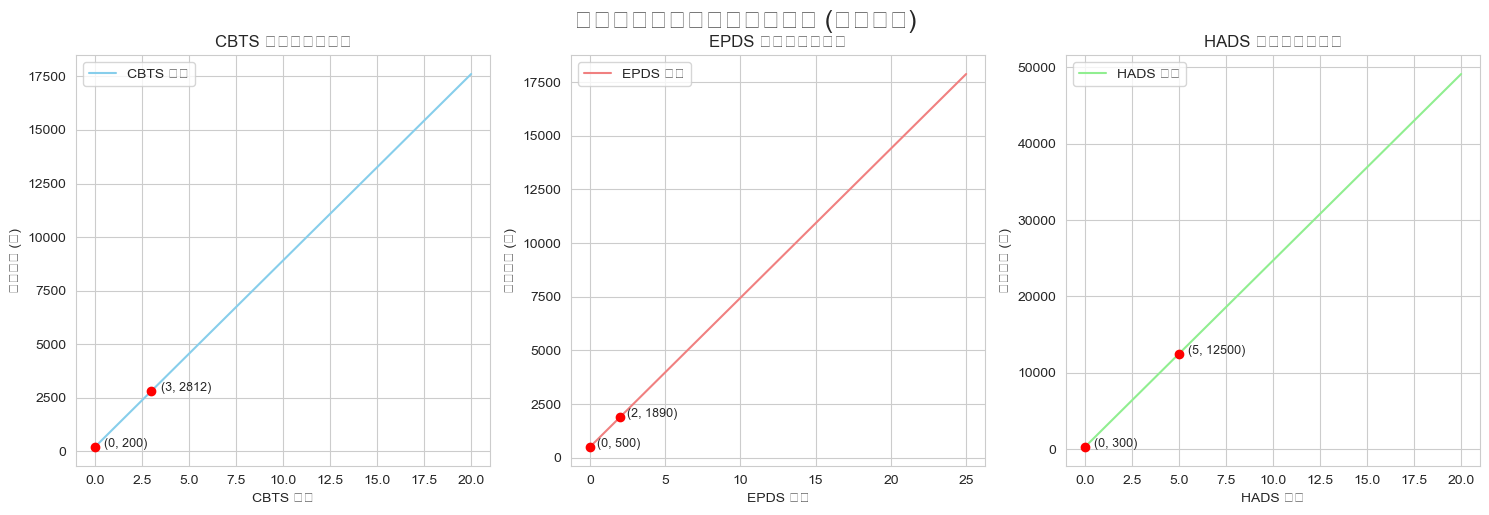

C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_12892\3546176153.py:127: UserWarning: Glyph 30103 (\N{CJK UNIFIED IDEOGRAPH-7597}) missing fro

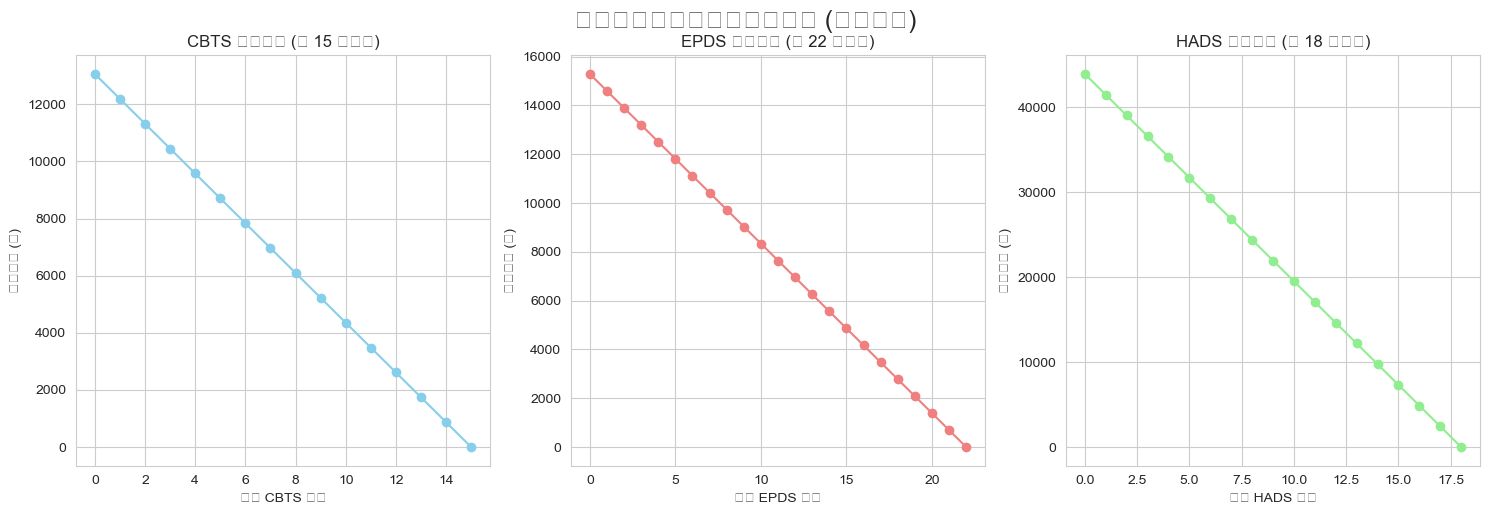

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题3：治疗费用模型评估与可视化 ---")

# --- 1. 重新计算线性治疗费用模型参数 (确保独立运行) ---
# 计算 m 和 c 参数 for C(s) = ms + c
def calculate_linear_cost_params(s1, c1, s2, c2):
    """Calculates m and c for C(s) = ms + c given two points."""
    if s1 == s2:
        raise ValueError("s1 and s2 cannot be the same for linear model.")
    m = (c2 - c1) / (s2 - s1)
    c = c1 - m * s1
    return m, c

# 获取每个量表的 m 和 c
m_cbts, c_cbts = calculate_linear_cost_params(0, 200, 3, 2812)
m_epds, c_epds = calculate_linear_cost_params(0, 500, 2, 1890)
m_hads, c_hads = calculate_linear_cost_params(0, 300, 5, 12500)

def get_cost_at_score_linear(score, m, c):
    """Calculates cost for a given score using derived m and c (linear model)."""
    return m * max(0, score) + c # score must be non-negative

print("治疗费用模型参数（线性）已加载：")
print(f"CBTS: C(s) = {m_cbts:.2f}s + {c_cbts:.2f}")
print(f"EPDS: C(s) = {m_epds:.2f}s + {c_epds:.2f}")
print(f"HADS: C(s) = {m_hads:.2f}s + {c_hads:.2f}")
print("-" * 60)

# --- 2. 绘制各量表治疗费用与得分关系图 ---
plt.figure(figsize=(15, 5))

# CBTS
s_cbts = np.linspace(0, 20, 100) # 假设CBTS最高分约为20 (根据数据范围和量表常见范围)
cost_cbts = [get_cost_at_score_linear(s, m_cbts, c_cbts) for s in s_cbts]
plt.subplot(1, 3, 1)
plt.plot(s_cbts, cost_cbts, label='CBTS 费用', color='skyblue')
plt.scatter([0, 3], [200, 2812], color='red', zorder=5) # 原始数据点
plt.text(0.5, 200, '(0, 200)', fontsize=9, ha='left')
plt.text(3.5, 2812, '(3, 2812)', fontsize=9, ha='left')
plt.title('CBTS 得分与治疗费用')
plt.xlabel('CBTS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)
plt.legend()

# EPDS
s_epds = np.linspace(0, 25, 100) # 假设EPDS最高分约为25
cost_epds = [get_cost_at_score_linear(s, m_epds, c_epds) for s in s_epds]
plt.subplot(1, 3, 2)
plt.plot(s_epds, cost_epds, label='EPDS 费用', color='lightcoral')
plt.scatter([0, 2], [500, 1890], color='red', zorder=5) # 原始数据点
plt.text(0.5, 500, '(0, 500)', fontsize=9, ha='left')
plt.text(2.5, 1890, '(2, 1890)', fontsize=9, ha='left')
plt.title('EPDS 得分与治疗费用')
plt.xlabel('EPDS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)
plt.legend()

# HADS
s_hads = np.linspace(0, 20, 100) # 假设HADS最高分约为20
cost_hads = [get_cost_at_score_linear(s, m_hads, c_hads) for s in s_hads]
plt.subplot(1, 3, 3)
plt.plot(s_hads, cost_hads, label='HADS 费用', color='lightgreen')
plt.scatter([0, 5], [300, 12500], color='red', zorder=5) # 原始数据点
plt.text(0.5, 300, '(0, 300)', fontsize=9, ha='left')
plt.text(5.5, 12500, '(5, 12500)', fontsize=9, ha='left')
plt.title('HADS 得分与治疗费用')
plt.xlabel('HADS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.suptitle('各量表得分与治疗费用关系图 (线性模型)', y=1.02, fontsize=18)
plt.show()

# --- 3. 绘制各量表费用降低曲线图 (从编号238的当前得分开始) ---
# 编号 238 婴儿的当前数据 (需要从前面代码获取，这里假设已获取)
# 为了独立运行，这里手动定义 238 的当前得分
current_cbts = 15
current_epds = 22
current_hads = 18

plt.figure(figsize=(15, 5))

# CBTS 费用降低
target_scores_cbts = np.arange(0, int(current_cbts) + 1) # 从当前得分到0
reduction_costs_cbts = [get_cost_at_score_linear(current_cbts, m_cbts, c_cbts) - get_cost_at_score_linear(s, m_cbts, c_cbts) for s in target_scores_cbts]
plt.subplot(1, 3, 1)
plt.plot(target_scores_cbts, reduction_costs_cbts, marker='o', linestyle='-', color='skyblue')
plt.title(f'CBTS 降低费用 (从 {current_cbts} 分开始)')
plt.xlabel('目标 CBTS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)

# EPDS 费用降低
target_scores_epds = np.arange(0, int(current_epds) + 1)
reduction_costs_epds = [get_cost_at_score_linear(current_epds, m_epds, c_epds) - get_cost_at_score_linear(s, m_epds, c_epds) for s in target_scores_epds]
plt.subplot(1, 3, 2)
plt.plot(target_scores_epds, reduction_costs_epds, marker='o', linestyle='-', color='lightcoral')
plt.title(f'EPDS 降低费用 (从 {current_epds} 分开始)')
plt.xlabel('目标 EPDS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)

# HADS 费用降低
target_scores_hads = np.arange(0, int(current_hads) + 1)
reduction_costs_hads = [get_cost_at_score_linear(current_hads, m_hads, c_hads) - get_cost_at_score_linear(s, m_hads, c_hads) for s in target_scores_hads]
plt.subplot(1, 3, 3)
plt.plot(target_scores_hads, reduction_costs_hads, marker='o', linestyle='-', color='lightgreen')
plt.title(f'HADS 降低费用 (从 {current_hads} 分开始)')
plt.xlabel('目标 HADS 得分')
plt.ylabel('治疗费用 (元)')
plt.grid(True)

plt.tight_layout()
plt.suptitle('各量表得分降低所需治疗费用 (线性模型)', y=1.02, fontsize=18)
plt.show()

